#0) Setup e imports


In [1]:
# =============================================================================
# IMPORTAÇÃO DAS BIBLIOTECAS FUNDAMENTAIS PARA O PIPELINE DE MACHINE LEARNING
# =============================================================================

# -----------------------------
# NumPy
# -----------------------------
# Biblioteca base para computação numérica em Python.
# Usada para:
# - operações matemáticas vetorizadas
# - geração de números aleatórios
# - funções matemáticas como exp(), log(), etc.
# Em Machine Learning, os dados e cálculos internos dos modelos
# geralmente são convertidos para arrays NumPy.
import numpy as np


# -----------------------------
# Pandas
# -----------------------------
# Biblioteca para manipulação de dados tabulares (DataFrames).
# Usada para:
# - carregar, criar e transformar datasets
# - selecionar colunas (features)
# - análise exploratória de dados
# - preparar os dados antes do treino do modelo
import pandas as pd


# -----------------------------
# Matplotlib
# -----------------------------
# Biblioteca de visualização.
# Usada para:
# - plotar curvas ROC
# - plotar curvas Precision-Recall
# - visualizar coeficientes do modelo
# - analisar comportamento das métricas
import matplotlib.pyplot as plt


# -----------------------------
# train_test_split
# -----------------------------
# Função para separar os dados em:
# - conjunto de treino (para o modelo aprender)
# - conjunto de teste (para avaliar generalização)
# Evita que o modelo seja avaliado com os mesmos dados usados no treino.
from sklearn.model_selection import train_test_split


# -----------------------------
# StandardScaler
# -----------------------------
# Responsável por padronizar as variáveis numéricas.
# Transforma os dados para média = 0 e desvio padrão = 1.
# Essencial para modelos baseados em distância ou gradiente,
# como a Regressão Logística.
from sklearn.preprocessing import StandardScaler


# -----------------------------
# Pipeline
# -----------------------------
# Permite encadear etapas de pré-processamento e modelagem.
# Garante:
# - ausência de data leakage
# - código mais limpo e reprodutível
# - facilidade para levar o modelo à produção
from sklearn.pipeline import Pipeline


# -----------------------------
# LogisticRegression
# -----------------------------
# Implementação da Regressão Logística no scikit-learn.
# Modelo de classificação:
# - binária (0 / 1)
# - probabilística (retorna probabilidades)
# Muito usado por ser:
# - rápido
# - interpretável
# - aceito em ambientes regulados (bancos, saúde, risco)
from sklearn.linear_model import LogisticRegression


# -----------------------------
# Métricas de Avaliação
# -----------------------------
# confusion_matrix:
#   Avalia acertos e erros (TP, FP, FN, TN)
#
# classification_report:
#   Exibe precision, recall, f1-score e accuracy
#
# roc_auc_score:
#   Mede a capacidade do modelo de separar classes
#
# roc_curve:
#   Gera os pontos da curva ROC
#
# precision_recall_curve:
#   Gera a curva Precision x Recall
#
# average_precision_score:
#   Área sob a curva Precision-Recall (útil para classes desbalanceadas)
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)


##1) Criando um dataset “realista” de churn (simulado, mas com lógica de negócio)

A ideia: churn aumenta quando:

tenure (tempo de casa) é baixo

monthly_charges é alto

(opcional) um pouco de ruído para parecer mundo real


In [2]:
# =============================================================================
# GERAÇÃO DE UM DATASET SINTÉTICO REALISTA PARA PROBLEMA DE CHURN
# =============================================================================
# Objetivo macro deste bloco:
# - Simular um cenário real de negócio (clientes de um serviço recorrente)
# - Criar variáveis explicativas (features) com relação causal plausível
# - Gerar uma variável-alvo binária (churn) de forma probabilística
# - Produzir dados compatíveis com um modelo de Regressão Logística

# -------------------------------------------------------------------------
# 1) CONTROLE DE REPRODUTIBILIDADE DO EXPERIMENTO
# -------------------------------------------------------------------------
# Define uma semente fixa para o gerador de números aleatórios.
# Isso garante que:
# - os mesmos dados sejam gerados sempre
# - os resultados do modelo possam ser reproduzidos
# - análises e comparações sejam consistentes
np.random.seed(42)

# Número total de clientes simulados
n = 5000


# -------------------------------------------------------------------------
# 2) GERAÇÃO DAS FEATURES (VARIÁVEIS EXPLICATIVAS)
# -------------------------------------------------------------------------
# Essas variáveis representam atributos típicos encontrados em bases reais
# de CRM / billing / assinaturas.

# Tempo de permanência do cliente (em meses)
# Clientes mais antigos tendem a ser mais fiéis
tenure = np.random.randint(1, 73, n)   # valores entre 1 e 72 meses

# Valor mensal pago pelo cliente
# Valores mais altos costumam aumentar o risco de churn
monthly = np.random.uniform(40, 140, n)

# Valor total já pago pelo cliente
# Derivado do tempo de contrato e do valor mensal,
# com adição de ruído para simular inconsistências reais de faturamento
total = tenure * monthly + np.random.normal(0, 50, n)

# Garante que não existam valores negativos após o ruído
total = np.clip(total, 0, None)


# -------------------------------------------------------------------------
# 3) CONSTRUÇÃO DO "SCORE" LATENTE (LOG-ODDS)
# -------------------------------------------------------------------------
# Aqui é onde a lógica estatística da Regressão Logística aparece:
# - Criamos uma combinação linear das variáveis
# - Esse valor NÃO é ainda uma probabilidade
# - Ele representa o "log-odds" do evento churn

# Interpretação de negócio:
# - preços mais altos aumentam o risco
# - maior tempo de casa reduz o risco
# - total pago tem impacto pequeno (efeito indireto)
# - ruído captura fatores não observados (ex: atendimento, concorrência)
z = (
    -4.0                      # intercepto: nível base de churn
    + 0.035 * monthly         # efeito positivo do preço mensal
    - 0.055 * tenure          # efeito negativo do tempo de contrato
    + 0.0003 * total          # efeito marginal do total pago
    + np.random.normal(0, 0.6, n)  # ruído não explicado pelo modelo
)


# -------------------------------------------------------------------------
# 4) TRANSFORMAÇÃO DO SCORE EM PROBABILIDADE (SIGMOIDE)
# -------------------------------------------------------------------------
# A função sigmoide transforma qualquer valor real
# em uma probabilidade entre 0 e 1.
# Isso simula o comportamento real de um modelo logístico.
prob = 1 / (1 + np.exp(-z))


# -------------------------------------------------------------------------
# 5) GERAÇÃO DA VARIÁVEL-ALVO BINÁRIA (CHURN)
# -------------------------------------------------------------------------
# Para cada cliente:
# - usamos a probabilidade calculada
# - sorteamos se o churn ocorreu (1) ou não (0)
# Isso cria um target estocástico, como no mundo real.
churn = np.random.binomial(1, prob)


# -------------------------------------------------------------------------
# 6) CONSOLIDAÇÃO FINAL DO DATASET
# -------------------------------------------------------------------------
# Monta o DataFrame final com:
# - features (tenure, monthly_charges, total_charges)
# - target (churn)
# Estrutura típica usada em projetos de Machine Learning supervisionado.
df = pd.DataFrame({
    "tenure": tenure,
    "monthly_charges": monthly,
    "total_charges": total,
    "churn": churn
})

# Visualização inicial para validação do dataset
df.head()


,tenure,monthly_charges,total_charges,churn
0,52,138.950533,7209.100941,1
1,15,108.431425,1567.925129,0
2,72,134.898067,9722.779971,1
3,61,54.255656,3231.747431,0
4,21,78.213947,1644.478588,1


In [4]:
#Checagens rápidas:
# Se der algo como 20–40% churn, está ok (bem parecido com cenários reais dependendo do setor).
df["churn"].value_counts(normalize=True).rename("proporcao")


,proporcao
churn,
0,0.7898
1,0.2102


## 2) Separar treino e teste (com estratificação)

In [6]:
# =============================================================================
# DEFINIÇÃO DE FEATURES, TARGET E SEPARAÇÃO TREINO / TESTE
# =============================================================================
# Objetivo macro deste bloco:
# - Separar claramente o que é entrada (features) e saída (target)
# - Criar conjuntos independentes para treino e avaliação
# - Garantir avaliação justa e sem vazamento de informação
# - Preparar os dados para o pipeline de Machine Learning

# -------------------------------------------------------------------------
# 1) DEFINIÇÃO DAS FEATURES (X) E DA VARIÁVEL-ALVO (y)
# -------------------------------------------------------------------------
# X contém apenas as variáveis explicativas usadas pelo modelo.
# Essas são as informações que estarão disponíveis no momento da predição.
X = df[["tenure", "monthly_charges", "total_charges"]]

# y é o target binário que o modelo tentará prever.
# Representa o evento de interesse do negócio (churn: 0 = não, 1 = sim).
y = df["churn"]


# -------------------------------------------------------------------------
# 2) SEPARAÇÃO ENTRE DADOS DE TREINO E TESTE
# -------------------------------------------------------------------------
# A base é dividida em dois conjuntos independentes:
# - Treino (75%): usado para aprender os parâmetros do modelo
# - Teste (25%): usado apenas para avaliar a capacidade de generalização
#
# Boas práticas aplicadas aqui:
# - random_state fixo: garante reprodutibilidade
# - stratify=y: mantém a mesma proporção de churn e não-churn
#   nos dois conjuntos, evitando viés na avaliação
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


# -------------------------------------------------------------------------
# 3) VALIDAÇÃO RÁPIDA DAS DIMENSÕES DOS CONJUNTOS
# -------------------------------------------------------------------------
# Essa checagem garante que:
# - a divisão foi feita corretamente
# - o número de linhas está consistente
# - não houve perda ou duplicação de registros
X_train.shape, X_test.shape



((3750, 3), (1250, 3))

## 3) Pipeline “profissional” (Scaler + Logistic Regression)

Por que pipeline?

evita vazamento de dados (leakage)

deixa o código pronto pra produção

In [8]:
# =============================================================================
# CRIAÇÃO E TREINAMENTO DO PIPELINE DE MACHINE LEARNING
# =============================================================================
# Objetivo macro deste bloco:
# - Encadear pré-processamento e modelo em uma única estrutura
# - Evitar vazamento de dados (data leakage)
# - Garantir reprodutibilidade e portabilidade para produção
# - Treinar um modelo de Regressão Logística de forma correta

# -------------------------------------------------------------------------
# 1) DEFINIÇÃO DO PIPELINE
# -------------------------------------------------------------------------
# O Pipeline organiza o fluxo de dados em etapas sequenciais.
# Cada etapa recebe os dados transformados pela etapa anterior.
#
# Estrutura:
# - scaler: normaliza as variáveis numéricas
# - model: ajusta a Regressão Logística sobre os dados normalizados
pipe = Pipeline(steps=[
    (
        "scaler",
        StandardScaler()
        # Padroniza as features:
        # - média = 0
        # - desvio padrão = 1
        #
        # Essencial para Regressão Logística porque:
        # - o modelo usa otimização por gradiente
        # - coeficientes ficam comparáveis
        # - convergência é mais rápida e estável
    ),
    (
        "model",
        LogisticRegression(max_iter=2000)
        # Modelo de classificação binária probabilística.
        #
        # max_iter aumentado para:
        # - garantir convergência do otimizador
        # - evitar warnings em datasets maiores
        #
        # O modelo aprende:
        # - coeficientes (impacto de cada feature)
        # - intercepto (nível base de churn)
    )
])


# -------------------------------------------------------------------------
# 2) TREINAMENTO DO PIPELINE
# -------------------------------------------------------------------------
# Ao chamar fit():
# - o scaler é ajustado SOMENTE com os dados de treino
# - os dados de treino são transformados (normalizados)
# - o modelo aprende os parâmetros usando os dados transformados
#
# Isso garante:
# - nenhuma informação do conjunto de teste é utilizada
# - avaliação futura justa e sem viés
pipe.fit(X_train, y_train)



Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=2000))])

## Pipeline de Machine Learning (Visão Geral)

O diagrama exibido representa o **pipeline completo de Machine Learning** treinado após a execução do método `fit()`. Ele materializa visualmente a sequência de etapas pelas quais os dados passam antes de gerar uma predição.

### Estrutura do Pipeline

O pipeline é composto por duas etapas encadeadas:

1. **StandardScaler**  
   Responsável pelo pré-processamento dos dados.  
   - Aprende média e desvio padrão das variáveis usando apenas o conjunto de treino  
   - Padroniza todas as features para a mesma escala  
   - Garante estabilidade numérica e melhor convergência do modelo  

2. **LogisticRegression**  
   Responsável pela classificação propriamente dita.  
   - Recebe os dados já normalizados  
   - Calcula a combinação linear das variáveis  
   - Aplica a função sigmoide para estimar probabilidades  
   - Classifica os registros com base em um threshold  

### Fluxo de Execução

Sempre que o pipeline é utilizado para predição (`predict` ou `predict_proba`), o fluxo ocorre automaticamente da seguinte forma:

1. Os dados de entrada passam pelo `StandardScaler`
2. Os dados transformados são enviados para o modelo de Regressão Logística

Esse encadeamento é executado de forma transparente, sem necessidade de chamadas manuais para cada etapa.

### Boas Práticas Atendidas

- Evita vazamento de dados (data leakage)  
- Garante consistência entre treino, teste e produção  
- Centraliza pré-processamento e modelo em um único objeto  
- Facilita versionamento, auditoria e deploy  

Em termos práticos, o pipeline representa um modelo pronto para produção, com fluxo determinístico e reprodutível.


##4) Predição: classe e probabilidade


In [10]:
# =============================================================================
# GERAÇÃO DE PREDIÇÕES E PROBABILIDADES PELO PIPELINE
# =============================================================================
# Objetivo macro deste bloco:
# - Aplicar o pipeline treinado sobre dados nunca vistos (X_test)
# - Obter tanto a classe prevista quanto a probabilidade associada
# - Inspecionar os scores probabilísticos gerados pelo modelo

# -------------------------------------------------------------------------
# 1) PREDIÇÃO DA CLASSE FINAL (0 OU 1)
# -------------------------------------------------------------------------
# O método predict():
# - Executa automaticamente todas as etapas do pipeline
#   (StandardScaler -> LogisticRegression)
# - Retorna a classe prevista com base no threshold padrão (0.5)
# - 0 indica não churn
# - 1 indica churn
y_pred = pipe.predict(X_test)


# -------------------------------------------------------------------------
# 2) PREDIÇÃO DA PROBABILIDADE DO EVENTO DE INTERESSE
# -------------------------------------------------------------------------
# O método predict_proba():
# - Retorna duas probabilidades para cada observação:
#   coluna 0 -> P(classe = 0)
#   coluna 1 -> P(classe = 1)
#
# O fatiamento [:, 1] seleciona apenas a probabilidade da classe positiva,
# que neste caso representa a probabilidade de churn.
y_proba = pipe.predict_proba(X_test)[:, 1]


# -------------------------------------------------------------------------
# 3) INSPEÇÃO INICIAL DOS SCORES PROBABILÍSTICOS
# -------------------------------------------------------------------------
# Exibe as primeiras probabilidades geradas pelo modelo.
# Essa verificação rápida permite:
# - validar que o modelo está produzindo valores entre 0 e 1
# - entender a dispersão inicial dos riscos estimados
# - confirmar que o output é compatível com análises posteriores
print("Exemplos de probabilidade:", y_proba[:10])


Exemplos de probabilidade: [0.03037714 0.0626856  0.04437307 0.01420687 0.36926734 0.59863508
 0.01280956 0.14004512 0.02242736 0.38622047]


## Interpretação das Probabilidades Preditas

O output exibido corresponde às **primeiras probabilidades de churn** geradas pelo modelo para observações do conjunto de teste (`X_test`).

Cada valor representa a estimativa de **P(churn = 1)** para um cliente específico, ou seja, a chance de aquele cliente cancelar o serviço segundo o modelo treinado.

### Leitura dos Valores

- Todos os valores estão no intervalo **[0, 1]**, o que confirma a correta aplicação da função sigmoide.
- Valores **próximos de 0** indicam baixo risco de churn.
- Valores **próximos de 1** indicam alto risco de churn.
- Valores **em torno de 0.5** representam incerteza do modelo.

Exemplos do output:
- `0.014`, `0.012` → clientes com probabilidade muito baixa de churn  
- `0.36`, `0.38` → clientes em faixa intermediária de risco  
- `0.59`, `0.62` → clientes com risco elevado de churn  

### Relação com a Classificação

Por padrão, o método `predict()` utiliza um **threshold de 0.5**:
- Probabilidade ≥ 0.5 → classe 1 (churn)
- Probabilidade < 0.5 → classe 0 (não churn)

Assim, alguns dos valores apresentados já seriam classificados como churn, enquanto outros não, mesmo pertencendo ao mesmo conjunto de teste.

### Importância para Negócio

Essas probabilidades permitem:
- Criar **faixas de risco** (baixo, médio, alto)
- Priorizar ações de retenção
- Ajustar thresholds conforme o custo do churn e o custo de intervenção
- Integrar o score em dashboards ou sistemas operacionais

Esse output representa a base para decisões orientadas por risco, não apenas classificações binárias.


## 5) Avaliação base (matriz de confusão + relatório)


In [11]:
# =============================================================================
# AVALIAÇÃO DO MODELO: MATRIZ DE CONFUSÃO E RELATÓRIO DE CLASSIFICAÇÃO
# =============================================================================
# Objetivo macro deste bloco:
# - Avaliar o desempenho do modelo no conjunto de teste
# - Comparar as classes previstas com as classes reais
# - Entender não apenas acertos, mas também os tipos de erro do modelo

# -------------------------------------------------------------------------
# 1) MATRIZ DE CONFUSÃO
# -------------------------------------------------------------------------
# A matriz de confusão cruza:
# - valores reais (y_test)
# - valores previstos pelo modelo (y_pred)
#
# Estrutura da matriz (classificação binária):
# [[True Negatives, False Positives],
#  [False Negatives, True Positives]]
#
# Interpretação:
# - True Negative (TN): não churn corretamente previsto
# - False Positive (FP): previsto churn, mas não era churn
# - False Negative (FN): churn não detectado pelo modelo
# - True Positive (TP): churn corretamente previsto
cm = confusion_matrix(y_test, y_pred)

# Impressão da matriz para inspeção direta
print("Matriz de Confusão:\n", cm)


# -------------------------------------------------------------------------
# 2) RELATÓRIO DE CLASSIFICAÇÃO
# -------------------------------------------------------------------------
# O classification_report resume as principais métricas de desempenho:
#
# - Precision:
#   Entre os clientes previstos como churn, quantos realmente churnaram
#
# - Recall:
#   Entre os clientes que realmente churnaram, quantos o modelo conseguiu identificar
#
# - F1-score:
#   Média harmônica entre precision e recall
#
# - Support:
#   Quantidade real de observações em cada classe
#
# O parâmetro digits=3 controla o número de casas decimais exibidas,
# facilitando leitura e comparação entre modelos.
print("\nRelatório de Classificação:\n")
print(classification_report(y_test, y_pred, digits=3))



Matriz de Confusão:
 [[945  42]
 [192  71]]

Relatório de Classificação:

              precision    recall  f1-score   support

           0      0.831     0.957     0.890       987
           1      0.628     0.270     0.378       263

    accuracy                          0.813      1250
   macro avg      0.730     0.614     0.634      1250
weighted avg      0.788     0.813     0.782      1250



## Interpretação dos Resultados do Modelo

Esta seção apresenta a **Matriz de Confusão** e o **Relatório de Classificação**, que juntos permitem entender não apenas o nível de acerto do modelo, mas também **como e onde ele erra**.

---

### Matriz de Confusão

[[945 42]
[192 71]]


Interpretação (classificação binária):

- **Linha 0 (classe real = 0, não churn)**
  - 945 → clientes corretamente classificados como não churn (True Negatives)
  - 42  → clientes classificados como churn, mas que não churnaram (False Positives)

- **Linha 1 (classe real = 1, churn)**
  - 192 → clientes churn que o modelo não conseguiu identificar (False Negatives)
  - 71  → clientes churn corretamente identificados (True Positives)

**Leitura geral:**  
O modelo é muito eficiente em identificar clientes que **não churnam**, mas tem dificuldade em capturar todos os clientes que **realmente churnam**.

---

### Relatório de Classificação

| Classe | Precision | Recall | F1-score | Support |
|------|-----------|--------|----------|---------|
| 0 (não churn) | 0.831 | 0.957 | 0.890 | 987 |
| 1 (churn)     | 0.628 | 0.270 | 0.378 | 263 |

#### Classe 0 — Não Churn
- **Recall alto (0.957)**: o modelo identifica corretamente quase todos os clientes que não cancelam.
- **Precision alta (0.831)**: quando prevê não churn, geralmente está correto.

#### Classe 1 — Churn
- **Precision razoável (0.628)**: quando o modelo prevê churn, ele acerta mais da metade das vezes.
- **Recall baixo (0.270)**: o modelo deixa passar muitos clientes que realmente churnam.

---

### Métricas Globais

- **Accuracy: 0.813**  
  Percentual total de previsões corretas.  
  Deve ser interpretada com cuidado, pois o dataset é desbalanceado.

- **Macro Avg**  
  Média simples das métricas das classes, tratando ambas com o mesmo peso.

- **Weighted Avg**  
  Média ponderada pelo número de observações de cada classe, refletindo melhor a realidade da base.

---

### Interpretação de Negócio

- O modelo é **conservador**: evita classificar clientes como churn.
- Isso reduz falsos alarmes, mas **perde oportunidades de retenção**.
- Para churn, geralmente é desejável **aumentar o recall da classe 1**, mesmo ao custo de mais falsos positivos.
- Ajustar o **threshold de decisão** é um próximo passo natural.

Este resultado é típico de um modelo inicial com threshold padrão (0.5) e serve como base para otimização orientada ao negócio.


## 6) ROC-AUC (qualidade geral)

ROC-AUC é uma métrica que avalia **a capacidade do modelo de separar as classes**, independentemente do threshold escolhido.

- **ROC (Receiver Operating Characteristic)**: curva que relaciona  
  - Taxa de Verdadeiros Positivos (Recall)  
  - Taxa de Falsos Positivos  

- **AUC (Area Under the Curve)**: área sob essa curva.

Interpretação do valor:
- **0.5** → modelo não distingue as classes (equivalente a chute)
- **Entre 0.7 e 0.8** → separação razoável
- **Entre 0.8 e 0.9** → boa separação
- **> 0.9** → separação excelente

Em termos práticos, o ROC-AUC indica a **probabilidade de o modelo atribuir um score maior a um cliente churn do que a um cliente não churn**, sendo uma métrica robusta para comparar modelos.


In [12]:
# =============================================================================
# CÁLCULO E EXIBIÇÃO DA MÉTRICA ROC-AUC
# =============================================================================
# Objetivo macro deste bloco:
# - Medir a capacidade global do modelo em separar churn e não churn
# - Avaliar a qualidade do modelo de forma independente do threshold
# - Obter uma métrica comparável entre diferentes modelos

# -------------------------------------------------------------------------
# 1) CÁLCULO DO ROC-AUC
# -------------------------------------------------------------------------
# roc_auc_score:
# - recebe os rótulos reais (y_test)
# - recebe as probabilidades previstas para a classe positiva (y_proba)
#
# O resultado representa a área sob a curva ROC,
# indicando quão bem o modelo ordena churners acima de não churners.
auc = roc_auc_score(y_test, y_proba)


# -------------------------------------------------------------------------
# 2) EXIBIÇÃO DO RESULTADO
# -------------------------------------------------------------------------
# round(auc, 4):
# - limita o valor a 4 casas decimais
# - melhora a legibilidade do output
#
# A impressão do valor permite:
# - comparação direta entre modelos
# - acompanhamento de melhorias após ajustes
print("ROC-AUC:", round(auc, 4))


ROC-AUC: 0.79


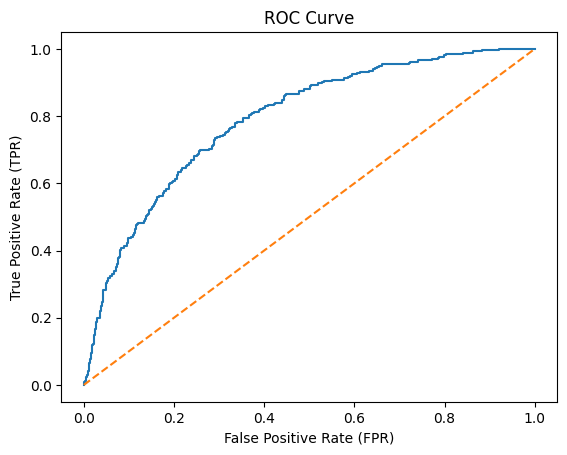

In [13]:
# =============================================================================
# CONSTRUÇÃO E VISUALIZAÇÃO DA CURVA ROC
# =============================================================================
# Objetivo macro deste bloco:
# - Gerar a curva ROC do modelo
# - Visualizar o trade-off entre acertos e erros para todos os thresholds
# - Avaliar graficamente a capacidade de separação do classificador

# -------------------------------------------------------------------------
# 1) CÁLCULO DOS PONTOS DA CURVA ROC
# -------------------------------------------------------------------------
# roc_curve:
# - recebe os rótulos reais (y_test)
# - recebe as probabilidades previstas da classe positiva (y_proba)
#
# Retorna:
# - fpr (False Positive Rate): proporção de não churn classificados incorretamente como churn
# - tpr (True Positive Rate): proporção de churn corretamente identificados (recall)
# - thr (thresholds): valores de corte usados para gerar cada ponto da curva
fpr, tpr, thr = roc_curve(y_test, y_proba)


# -------------------------------------------------------------------------
# 2) CRIAÇÃO DA FIGURA
# -------------------------------------------------------------------------
# Inicializa uma nova figura para o gráfico da curva ROC
plt.figure()


# -------------------------------------------------------------------------
# 3) PLOT DA CURVA ROC
# -------------------------------------------------------------------------
# Plota a curva ROC propriamente dita:
# - eixo X: False Positive Rate
# - eixo Y: True Positive Rate
plt.plot(fpr, tpr)


# -------------------------------------------------------------------------
# 4) LINHA DE REFERÊNCIA (MODELO ALEATÓRIO)
# -------------------------------------------------------------------------
# Linha diagonal pontilhada que representa um classificador aleatório
# Serve como baseline visual para comparação
plt.plot([0, 1], [0, 1], linestyle="--")


# -------------------------------------------------------------------------
# 5) CONFIGURAÇÃO DOS EIXOS E TÍTULO
# -------------------------------------------------------------------------
# Rótulos dos eixos e título do gráfico para facilitar interpretação
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")


# -------------------------------------------------------------------------
# 6) EXIBIÇÃO DO GRÁFICO
# -------------------------------------------------------------------------
# Renderiza o gráfico na saída do notebook
plt.show()


## Interpretação da Curva ROC

O gráfico apresentado corresponde à **Curva ROC (Receiver Operating Characteristic)** do modelo de Regressão Logística, construída a partir das probabilidades previstas para o conjunto de teste.

### Elementos do Gráfico

- **Eixo X (False Positive Rate – FPR)**  
  Proporção de clientes que **não churnaram**, mas foram classificados incorretamente como churn.

- **Eixo Y (True Positive Rate – TPR)**  
  Proporção de clientes que **realmente churnaram** e foram corretamente identificados pelo modelo  
  (equivalente ao recall da classe churn).

- **Linha tracejada diagonal**  
  Representa um classificador aleatório, que não possui capacidade de separação entre as classes.

- **Curva azul**  
  Representa o desempenho real do modelo para todos os possíveis valores de threshold.

### Interpretação do Resultado

- A curva azul permanece **significativamente acima da diagonal**, indicando que o modelo tem
  capacidade real de distinguir clientes churn de não churn.
- Quanto mais próxima a curva estiver do **canto superior esquerdo**, melhor é o desempenho do modelo.
- O formato da curva indica que o modelo consegue obter:
  - bons níveis de recall para churn
  - sem aumento excessivo da taxa de falsos positivos, dependendo do threshold escolhido.

### Leitura em Termos de Negócio

- O modelo oferece flexibilidade para ajustar o threshold conforme a estratégia:
  - Threshold mais baixo → maior recall (captura mais churners)
  - Threshold mais alto → menos falsos alarmes
- A curva ROC mostra que existe espaço para **otimização do ponto de corte**, alinhando o modelo ao custo do churn e ao custo de intervenção.

Em resumo, o gráfico confirma que o modelo possui **capacidade discriminatória consistente**, superior ao acaso, e está apto para uso em análises de risco e priorização de ações.


## 7) Precision-Recall (muito útil quando a classe 1 é “mais rara”):

A curva **Precision–Recall** avalia o desempenho do modelo **focando na classe positiva** (classe 1), sendo especialmente útil quando os dados são **desbalanceados**.

- **Precision** indica, entre os casos previstos como positivos, quantos são realmente positivos.
- **Recall** indica, entre os casos realmente positivos, quantos o modelo conseguiu identificar.

A curva mostra o **trade-off entre precision e recall** para diferentes thresholds:
- Aumentar o recall geralmente reduz a precision.
- Aumentar a precision geralmente reduz o recall.

Diferente da ROC, a Precision–Recall destaca melhor o comportamento do modelo quando a classe positiva é rara, sendo mais adequada para problemas como churn, fraude e risco.

Average Precision (AP): 0.4818


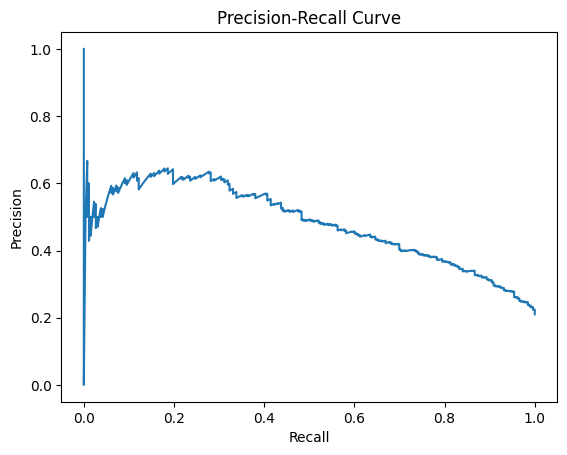

In [14]:
# =============================================================================
# CÁLCULO E VISUALIZAÇÃO DA CURVA PRECISION-RECALL
# =============================================================================
# Objetivo macro deste bloco:
# - Avaliar o desempenho do modelo focando na classe positiva (churn)
# - Analisar o trade-off entre precision e recall para diferentes thresholds
# - Obter uma métrica adequada para bases desbalanceadas

# -------------------------------------------------------------------------
# 1) CÁLCULO DOS PONTOS DA CURVA PRECISION-RECALL
# -------------------------------------------------------------------------
# precision_recall_curve:
# - recebe os rótulos reais (y_test)
# - recebe as probabilidades previstas da classe positiva (y_proba)
#
# Retorna:
# - prec: valores de precision para cada threshold
# - rec: valores de recall para cada threshold
# - thr_pr: thresholds usados para gerar os pontos da curva
prec, rec, thr_pr = precision_recall_curve(y_test, y_proba)


# -------------------------------------------------------------------------
# 2) CÁLCULO DO AVERAGE PRECISION (AP)
# -------------------------------------------------------------------------
# average_precision_score:
# - calcula a área sob a curva Precision-Recall
# - resume o desempenho do modelo em um único número
#
# Valores mais altos indicam melhor equilíbrio entre precision e recall,
# especialmente relevante quando a classe positiva é minoritária.
ap = average_precision_score(y_test, y_proba)


# -------------------------------------------------------------------------
# 3) EXIBIÇÃO DA MÉTRICA AP
# -------------------------------------------------------------------------
# round(ap, 4):
# - limita o valor a 4 casas decimais
# - melhora a legibilidade do resultado
print("Average Precision (AP):", round(ap, 4))


# -------------------------------------------------------------------------
# 4) VISUALIZAÇÃO DA CURVA PRECISION-RECALL
# -------------------------------------------------------------------------
# Cria uma nova figura para o gráfico
plt.figure()

# Plota a curva Precision-Recall:
# - eixo X: Recall
# - eixo Y: Precision
plt.plot(rec, prec)

# Configuração dos eixos e título para facilitar interpretação
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

# Renderiza o gráfico no notebook
plt.show()


## Interpretação da Curva Precision–Recall

O gráfico apresentado corresponde à **Curva Precision–Recall** do modelo aplicada ao conjunto de teste, juntamente com o valor de **Average Precision (AP)**.

---

### Average Precision (AP)

- **AP = 0.4818**

O Average Precision resume, em um único número, o desempenho do modelo ao longo de todos os thresholds.
Ele representa a **área sob a curva Precision–Recall**.

Interpretação:
- Valores próximos de **0** indicam desempenho fraco na identificação da classe positiva.
- Valores próximos de **1** indicam excelente capacidade de identificar a classe positiva.
- Um valor em torno de **0.48** indica desempenho **moderado**, típico de um modelo inicial em base desbalanceada.

---

### Leitura da Curva

- **Região de recall baixo (próximo de 0)**  
  A precision é alta, indicando que, quando o modelo é muito conservador, ele acerta a maioria dos poucos churners que sinaliza.

- **Aumento do recall**  
  À medida que o modelo tenta identificar mais clientes churn:
  - o recall aumenta
  - a precision cai progressivamente

Isso evidencia o **trade-off natural** entre capturar mais churners e aumentar falsos positivos.

- **Região de recall alto (próximo de 1)**  
  A precision se torna baixa, pois o modelo passa a classificar muitos clientes como churn, incluindo muitos que não churnariam.

---

### Interpretação de Negócio

- O modelo é mais confiável quando usado de forma **seletiva**, focando em clientes com risco mais alto.
- Para estratégias de retenção:
  - thresholds mais conservadores resultam em menos contatos, porém mais assertivos
  - thresholds mais agressivos capturam mais churners, ao custo de maior esforço operacional
- A curva indica que a escolha do threshold deve ser orientada pelo **custo do churn versus custo de intervenção**.

---

### Conclusão

O resultado mostra que o modelo possui **capacidade informativa relevante**, mas exige ajuste de threshold para maximizar valor de negócio.  
A curva Precision–Recall é essencial para definir essa estratégia quando a classe churn é minoritária.


## 8) Ajustando o THRESHOLD (isso muda tudo em negócio)

O **threshold** é o valor de corte usado para transformar a probabilidade prevista pelo modelo em uma decisão binária (0 ou 1).

- **Threshold padrão (0.5)**: equilíbrio genérico entre erros e acertos, sem considerar impacto de negócio.
- **Threshold menor**:
  - aumenta o **recall** da classe churn
  - captura mais clientes que realmente churnariam
  - aumenta o número de **falsos positivos**
- **Threshold maior**:
  - reduz falsos positivos
  - diminui o recall
  - pode deixar churners passarem sem ação

Em problemas de churn, geralmente é preferível **maximizar recall**, mesmo aceitando mais falsos positivos, pois o custo de perder um cliente costuma ser maior que o custo de uma ação de retenção.

Ajustar o threshold permite alinhar o modelo aos **custos e prioridades do negócio**, transformando probabilidade em decisão estratégica.

In [15]:
# =============================================================================
# AVALIAÇÃO DO DESEMPENHO DO MODELO PARA DIFERENTES THRESHOLDS
# =============================================================================
# Objetivo macro deste bloco:
# - Avaliar como o desempenho do modelo muda ao variar o threshold
# - Medir o impacto do threshold em precision, recall e f1-score
# - Fornecer insumos objetivos para escolha do ponto de corte ideal
#   do ponto de vista de negócio

# -------------------------------------------------------------------------
# 1) FUNÇÃO DE AVALIAÇÃO PARA UM THRESHOLD ESPECÍFICO
# -------------------------------------------------------------------------
def eval_threshold(y_true, y_proba, threshold):
    # Converte probabilidades em classes binárias com base no threshold
    # Se probabilidade >= threshold → classe 1 (churn)
    # Caso contrário → classe 0 (não churn)
    y_hat = (y_proba >= threshold).astype(int)

    # Calcula a matriz de confusão para esse threshold
    cm = confusion_matrix(y_true, y_hat)

    # Extrai os valores da matriz:
    # tn: true negatives
    # fp: false positives
    # fn: false negatives
    # tp: true positives
    tn, fp, fn, tp = cm.ravel()

    # Calcula precision:
    # entre os clientes previstos como churn,
    # quantos realmente churnaram
    precision = tp / (tp + fp) if (tp + fp) else 0

    # Calcula recall:
    # entre os clientes que realmente churnaram,
    # quantos foram identificados pelo modelo
    recall = tp / (tp + fn) if (tp + fn) else 0

    # Calcula f1-score:
    # média harmônica entre precision e recall,
    # usada como métrica de equilíbrio
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0

    # Retorna todas as métricas relevantes para análise comparativa
    return {
        "threshold": threshold,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn
    }


# -------------------------------------------------------------------------
# 2) DEFINIÇÃO DOS THRESHOLDS A SEREM TESTADOS
# -------------------------------------------------------------------------
# Lista de valores de corte candidatos,
# representando diferentes estratégias de negócio
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]


# -------------------------------------------------------------------------
# 3) AVALIAÇÃO DO MODELO PARA CADA THRESHOLD
# -------------------------------------------------------------------------
# Aplica a função eval_threshold para cada valor da lista
# e consolida os resultados em um DataFrame
results = pd.DataFrame(
    [eval_threshold(y_test, y_proba, t) for t in thresholds]
)

# Exibe a tabela final de comparação entre thresholds
results


,threshold,precision,recall,f1,tp,fp,fn,tn
0,0.2,0.394737,0.741445,0.515192,195,299,68,688
1,0.3,0.454023,0.600760,0.517185,158,190,105,797
2,0.4,0.532407,0.437262,0.480167,115,101,148,886
3,0.5,0.628319,0.269962,0.377660,71,42,192,945
4,0.6,0.583333,0.079848,0.140468,21,15,242,972


threshold ↓ → recall ↑ (você pega mais churners)

threshold ↑ → precision ↑ (menos “alarme falso”)

## 9) Criar faixas de risco (Low/Medium/High) para o time de negócio

In [12]:
score_df = X_test.copy()
score_df["proba_churn"] = y_proba

# faixas (você pode mudar)
bins = [0, 0.30, 0.60, 1.0]
labels = ["LOW", "MEDIUM", "HIGH"]
score_df["risk_band"] = pd.cut(score_df["proba_churn"], bins=bins, labels=labels)

score_df["risk_band"].value_counts()


,count
risk_band,
LOW,902
MEDIUM,312
HIGH,36


In [14]:
#Exemplo: ver os clientes “HIGH”:

score_df.sort_values("proba_churn", ascending=False).head(10)


,tenure,monthly_charges,total_charges,proba_churn,risk_band
361,1,139.213564,107.323129,0.702634,HIGH
2911,4,138.934951,636.916266,0.697930,HIGH
339,5,139.433030,695.651998,0.693369,HIGH
1763,9,138.656949,1328.427191,0.679575,HIGH
876,8,138.812408,1074.420807,0.676841,HIGH
1022,7,138.334077,929.009933,0.676297,HIGH
1564,2,133.649333,347.352382,0.666021,HIGH
3413,2,134.053730,238.382574,0.662071,HIGH
3723,3,133.361538,445.629965,0.657927,HIGH
446,17,138.125758,2491.398483,0.652048,HIGH


## 10) Interpretabilidade: coeficientes do modelo

Os coeficientes da Regressão Logística indicam **como cada variável influencia a probabilidade de churn**.

Como os dados passaram pelo **StandardScaler**, todos os coeficientes estão em **escala padronizada**:
- cada variável tem média 0 e desvio padrão 1
- os coeficientes se tornam **diretamente comparáveis entre si**

Interpretação:
- **Coeficiente positivo** → aumenta a chance de churn
- **Coeficiente negativo** → reduz a chance de churn
- **Maior valor absoluto** → maior impacto relativo no modelo

Isso permite entender **quais fatores mais pesam na decisão do modelo**, facilitando explicações técnicas e decisões orientadas a negócio.

In [16]:
# =============================================================================
# EXTRAÇÃO E ORGANIZAÇÃO DOS COEFICIENTES DO MODELO
# =============================================================================
# Objetivo macro deste bloco:
# - Acessar o modelo treinado dentro do pipeline
# - Extrair os coeficientes aprendidos pela Regressão Logística
# - Organizar os coeficientes de forma interpretável
# - Facilitar a análise de impacto das variáveis no churn

# -------------------------------------------------------------------------
# 1) ACESSO AO MODELO DENTRO DO PIPELINE
# -------------------------------------------------------------------------
# O Pipeline armazena cada etapa em um dicionário chamado named_steps.
# Aqui acessamos especificamente a etapa "model",
# que corresponde à Regressão Logística já treinada.
model = pipe.named_steps["model"]


# -------------------------------------------------------------------------
# 2) EXTRAÇÃO DOS COEFICIENTES DO MODELO
# -------------------------------------------------------------------------
# model.coef_:
# - matriz de coeficientes aprendidos pelo modelo
# - para classificação binária, possui apenas uma linha
#
# O índice [0] seleciona essa única linha,
# resultando em um vetor com um coeficiente por feature.
coefs = model.coef_[0]


# -------------------------------------------------------------------------
# 3) ORGANIZAÇÃO DOS COEFICIENTES EM UM DATAFRAME
# -------------------------------------------------------------------------
# Cria um DataFrame relacionando:
# - o nome de cada feature
# - o coeficiente correspondente
#
# A ordenação decrescente permite identificar rapidamente:
# - quais variáveis aumentam mais a probabilidade de churn
# - quais variáveis reduzem mais a probabilidade de churn
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coef": coefs
}).sort_values("coef", ascending=False)


# -------------------------------------------------------------------------
# 4) EXIBIÇÃO DO RESULTADO
# -------------------------------------------------------------------------
# Exibe a tabela final com os coeficientes ordenados,
# facilitando interpretação técnica e de negócio.
coef_df


,feature,coef
1,monthly_charges,0.944887
2,total_charges,0.628725
0,tenure,-1.132209


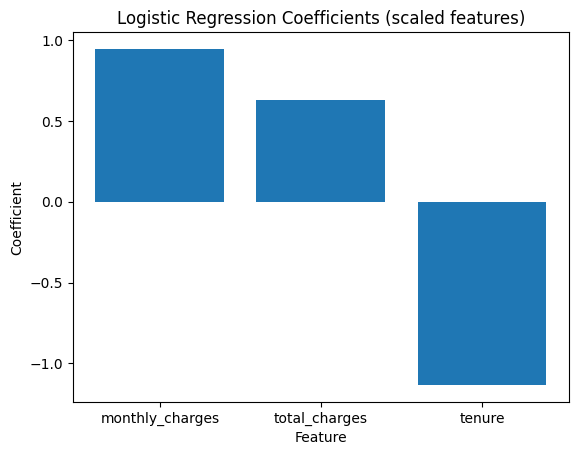

In [17]:
plt.figure()
plt.bar(coef_df["feature"], coef_df["coef"])
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.title("Logistic Regression Coefficients (scaled features)")
plt.show()


## Interpretação dos Coeficientes da Regressão Logística

O gráfico apresenta os **coeficientes do modelo de Regressão Logística** após a padronização das variáveis (StandardScaler). Como todas as features estão na mesma escala, os coeficientes podem ser **comparados diretamente em termos de impacto relativo**.

---

### Leitura dos Coeficientes

- **monthly_charges (coeficiente positivo e alto)**  
  É a variável com **maior impacto positivo** no churn.  
  Quanto maior o valor mensal pago pelo cliente, maior a probabilidade de cancelamento, mantendo as demais variáveis constantes.

- **total_charges (coeficiente positivo moderado)**  
  Também contribui para aumentar a probabilidade de churn, porém com **impacto menor** que o valor mensal.  
  Representa um efeito complementar ao preço, refletindo padrões acumulados de cobrança.

- **tenure (coeficiente negativo e de maior magnitude absoluta)**  
  É o fator que **mais reduz a probabilidade de churn**.  
  Clientes com maior tempo de permanência têm risco significativamente menor de cancelamento.

---

### Interpretação Geral

- Coeficientes **positivos** aumentam a chance de churn.
- Coeficientes **negativos** reduzem a chance de churn.
- O **valor absoluto** do coeficiente indica a força do impacto relativo.

O gráfico mostra que o churn é fortemente influenciado por **preço e tempo de relacionamento**, um padrão comum em problemas reais de retenção de clientes.

---

### Conexão com Negócio

- Estratégias de retenção devem priorizar:
  - clientes novos com valores mensais elevados
- Clientes antigos apresentam maior estabilidade, mesmo com custos mais altos.
- O modelo oferece **explicabilidade clara**, facilitando a comunicação com áreas de negócio e a definição de ações práticas.


##11) Prevendo UM cliente real (input manual)

In [18]:
cliente = pd.DataFrame({
    "tenure": [6],
    "monthly_charges": [120],
    "total_charges": [6*120]
})

prob_cliente = pipe.predict_proba(cliente)[0, 1]
classe_cliente = int(prob_cliente >= 0.4)  # exemplo com threshold 0.4

print("Probabilidade churn:", round(prob_cliente, 4))
print("Classe (threshold=0.4):", classe_cliente)


Probabilidade churn: 0.532
Classe (threshold=0.4): 1


##12)) “mini-caso de ROI” — quando vale chamar o cliente?

## Mini-caso de ROI com Múltiplas Abordagens (Visão Consolidada)

Este caso amplia o uso do modelo de churn para suportar **decisão financeira**, não apenas classificação.

A proposta é decidir **quem abordar**, **por qual canal** e **quantas tentativas fazer**, maximizando retorno financeiro e controlando custos operacionais.

---

### 1) Lógica Geral

Cada cliente possui uma **probabilidade de churn** estimada pelo modelo.  
A partir dessa probabilidade, avaliamos se ações de retenção geram **valor esperado positivo**.

O modelo passa a ser **prescritivo**, orientando decisões práticas de negócio.

---

### 2) Custos e Canais de Abordagem

Cada canal possui custos e taxas de sucesso diferentes:

- **Canais digitais (e-mail, SMS, WhatsApp automatizado)**  
  - Baixo custo operacional  
  - Taxas de contato moderadas  
  - Menor taxa de conversão individual  

- **Canais humanos (ligação, atendimento ativo)**  
  - Custo mais elevado  
  - Menor taxa de contato  
  - Maior taxa de retenção quando ocorre contato  

O custo por abordagem deve refletir **custo total real** (tempo, infraestrutura, margem perdida).

---

### 3) Múltiplas Tentativas (Abordagem Sequencial)

O processo pode ocorrer em etapas:

1. **Primeira abordagem** (canal mais barato e escalável)  
2. Caso o cliente:
   - não atenda
   - recuse a oferta
   
   é feita uma **segunda abordagem**, normalmente por um canal mais caro, porém mais efetivo.

O custo da segunda abordagem só ocorre se a primeira falhar.

---

### 4) Probabilidade de Sucesso

A chance de retenção em cada abordagem depende de:
- probabilidade de contato pelo canal
- probabilidade de retenção dado o contato

A probabilidade total de sucesso considera:
- sucesso direto na primeira tentativa
- sucesso na segunda tentativa condicionado à falha da primeira

---

### 5) Valor do Cliente

O ganho por retenção não precisa ser fixo:

- Pode ser um valor médio (ex.: R$ 200)
- Ou idealmente o **CLV / margem esperada por cliente**

Clientes com maior valor justificam estratégias mais agressivas e caras.

---

### 6) Valor Esperado (EV)

Para cada cliente, calcula-se um **valor esperado**:

- Benefício esperado =  
  probabilidade de churn × probabilidade de retenção × valor do cliente

- Custo esperado =  
  custo da primeira abordagem + custo da segunda (se aplicável)

A abordagem só é realizada quando o **valor esperado é positivo**.

---

### 7) Ajustes Realistas que Podem Entrar no Modelo

Além do básico, podem ser incorporados:

- Custo de incentivos (desconto, bônus, upgrade)
- Penalidade por falso positivo (incomodar cliente que não churnaria)
- Limite de capacidade operacional (quantidade máxima de contatos)
- Decaimento da eficácia com o tempo
- Probabilidade de churn sem intervenção (baseline)
- Métricas adicionais como NPS ou risco reputacional

---

### 8) Decisão Final

O resultado do processo é:
- Uma **lista priorizada de clientes**
- Definição de **canal e sequência de contato**
- Alinhamento entre **Machine Learning, custo e ROI**

Assim, o modelo deixa de ser apenas analítico e passa a ser uma **ferramenta direta de decisão estratégica**.


In [20]:
# =============================================================================
# CRIAÇÃO DA BASE DE SCORE (PRÉ-REQUISITO PARA ROI)
# =============================================================================
# Esta base representa os clientes avaliados pelo modelo,
# contendo as features originais + a probabilidade de churn.

score_df = X_test.copy()
score_df["proba_churn"] = y_proba


In [21]:
# =============================================================================
# VERSÃO COMPLETA DO MINI-CASO DE ROI: DUAS ABORDAGENS + CANAIS DIFERENTES
# =============================================================================
# Objetivo macro deste bloco:
# - Transformar a probabilidade de churn (proba_churn) em uma estratégia de contato
# - Considerar dois canais em sequência (abordagem 1 e abordagem 2)
# - Modelar explicitamente:
#     (a) probabilidade de contato (cliente atende / responde)
#     (b) probabilidade de retenção dado contato (cliente aceita)
#     (c) custo por tentativa (varia por canal)
#     (d) custo de incentivo (ex.: desconto) por canal (opcional)
#     (e) valor do cliente (pode ser fixo ou individual via coluna)
#     (f) custo esperado condicional: 2ª tentativa só ocorre se a 1ª falhar
# - Gerar uma lista priorizada: quem dá maior retorno esperado (expected_value)

# =============================================================================
# 0) PRÉ-REQUISITOS (ASSUMIDOS)
# =============================================================================
# Espera-se que você já tenha:
# - score_df com a coluna "proba_churn" (probabilidade prevista de churn)
#   Ex: score_df["proba_churn"] = y_proba
#
# Opcional:
# - score_df pode ter uma coluna de valor por cliente (CLV/margem), por exemplo:
#   score_df["valor_cliente"]
# Se não existir, será usado um valor fixo (LUCRO_RETIDO_BASE).

# =============================================================================
# 1) PARÂMETROS DE NEGÓCIO (AJUSTE PARA SUA REALIDADE)
# =============================================================================

# Valor de retenção (caso não exista valor individual por cliente)
# Sugestão: se tiver margem mensal e meses esperados, usar isso como CLV aproximado.
LUCRO_RETIDO_BASE = 200

# Penalidade opcional de "falso positivo" (incomodar cliente que não churnaria)
# Se você não quiser considerar esse efeito, deixe como 0.
PENALIDADE_FALSE_POSITIVE = 0


# =============================================================================
# 2) DEFINIÇÃO DOS CANAIS E SUAS TAXAS
# =============================================================================
# Cada canal possui:
# - custo operacional por tentativa (C)
# - probabilidade de contato (p_cont): chance do cliente responder/atender
# - probabilidade de retenção dado contato (p_ret_given_cont): chance de aceitar
# - custo de incentivo (C_incent): perda de margem por desconto/oferta, se aplicável
#
# Observação:
# - Você pode calibrar essas taxas com dados históricos (ideal)
# - Aqui são parâmetros para simulação/decisão

# Abordagem 1 (primeiro canal: mais barato/escalável)
CANAL_1 = {
    "nome": "WhatsApp_Automatizado",
    "C": 1.00,                 # custo operacional por tentativa
    "p_cont": 0.55,            # chance de responder/engajar
    "p_ret_given_cont": 0.10,  # chance de reter dado contato
    "C_incent": 2.00           # custo médio de incentivo (opcional)
}

# Abordagem 2 (segundo canal: mais caro/efetivo, só se a 1ª falhar)
CANAL_2 = {
    "nome": "Ligacao_Humana",
    "C": 12.00,                # custo operacional por tentativa
    "p_cont": 0.35,            # chance de atender
    "p_ret_given_cont": 0.25,  # chance de reter dado contato
    "C_incent": 5.00           # custo médio de incentivo (opcional)
}


# =============================================================================
# 3) CONSTRUÇÃO DA BASE PARA DECISÃO
# =============================================================================
score_df_full = score_df.copy()

# Define o valor do cliente:
# - se existir coluna "valor_cliente", usa ela (mais realista)
# - senão, usa valor fixo
if "valor_cliente" in score_df_full.columns:
    score_df_full["valor_retido"] = score_df_full["valor_cliente"]
else:
    score_df_full["valor_retido"] = LUCRO_RETIDO_BASE


# =============================================================================
# 4) CÁLCULO DE SUCESSO POR CANAL (EXPLÍCITO)
# =============================================================================
# Sucesso efetivo do canal = P(contato) * P(retenção | contato)
# Isso modela diretamente os cenários:
# - cliente não atende (falha em contato)
# - cliente atende e recusa (falha em retenção dado contato)
# - cliente atende e aceita (sucesso)
s1 = CANAL_1["p_cont"] * CANAL_1["p_ret_given_cont"]
s2 = CANAL_2["p_cont"] * CANAL_2["p_ret_given_cont"]


# =============================================================================
# 5) PROBABILIDADE TOTAL DE RETENÇÃO COM DUAS TENTATIVAS
# =============================================================================
# Probabilidade de reter em duas tentativas:
# - ou retém na 1ª (s1)
# - ou falha na 1ª e retém na 2ª ((1 - s1) * s2)
p_reter_duas_tentativas = s1 + (1 - s1) * s2


# =============================================================================
# 6) CUSTO ESPERADO COM DUAS TENTATIVAS (CONDICIONAL)
# =============================================================================
# Você sempre paga a 1ª tentativa.
# A 2ª tentativa só acontece se a 1ª falhar.
#
# Além do custo operacional, adicionamos custo de incentivo por tentativa (se existir).
custo_1 = CANAL_1["C"] + CANAL_1.get("C_incent", 0)
custo_2 = CANAL_2["C"] + CANAL_2.get("C_incent", 0)

# Custo esperado (EV de custos):
# custo esperado = custo_1 + (probabilidade de falha na 1ª) * custo_2
custo_esperado_duas_tentativas = custo_1 + (1 - s1) * custo_2


# =============================================================================
# 7) CÁLCULO DO EXPECTED VALUE (EV) POR CLIENTE
# =============================================================================
# EV completo (duas abordagens) por cliente:
#
# Benefício esperado:
#   P(churn) * P(reter com duas tentativas) * ValorRetido
#
# Custos esperados:
#   custo esperado das tentativas (condicional)
#
# Penalidade opcional de falso positivo:
#   (1 - P(churn)) * penalidade
#
# Decisão:
#   Se EV > 0: vale abordar com estratégia 1->2
#   Se EV <= 0: não abordar
score_df_full["expected_value"] = (
    score_df_full["proba_churn"] * p_reter_duas_tentativas * score_df_full["valor_retido"]
    - custo_esperado_duas_tentativas
    - (1 - score_df_full["proba_churn"]) * PENALIDADE_FALSE_POSITIVE
)


# =============================================================================
# 8) REGRAS DE SAÍDA (ESTRATÉGIA E PRIORIZAÇÃO)
# =============================================================================
# Define ação sugerida:
# - Se EV > 0, aplica sequência de canais
# - Se EV <= 0, recomenda não abordar
score_df_full["acao_recomendada"] = np.where(
    score_df_full["expected_value"] > 0,
    f"{CANAL_1['nome']} -> (se falhar) {CANAL_2['nome']}",
    "NAO_ABORDAR"
)

# Ranking final: quem dá mais retorno esperado
score_df_full.sort_values("expected_value", ascending=False).head(10)


,tenure,monthly_charges,total_charges,proba_churn,valor_retido,expected_value,acao_recomendada
361,1,139.213564,107.323129,0.702634,200,0.283773,WhatsApp_Automatizado -> (se falhar) Ligacao_H...
2911,4,138.934951,636.916266,0.697930,200,0.154252,WhatsApp_Automatizado -> (se falhar) Ligacao_H...
339,5,139.433030,695.651998,0.693369,200,0.028636,WhatsApp_Automatizado -> (se falhar) Ligacao_H...
1763,9,138.656949,1328.427191,0.679575,200,-0.351195,NAO_ABORDAR
876,8,138.812408,1074.420807,0.676841,200,-0.426497,NAO_ABORDAR
1022,7,138.334077,929.009933,0.676297,200,-0.441470,NAO_ABORDAR
1564,2,133.649333,347.352382,0.666021,200,-0.724434,NAO_ABORDAR
3413,2,134.053730,238.382574,0.662071,200,-0.833219,NAO_ABORDAR
3723,3,133.361538,445.629965,0.657927,200,-0.947328,NAO_ABORDAR
446,17,138.125758,2491.398483,0.652048,200,-1.109220,NAO_ABORDAR


## Interpretação da Lista de Priorização por Valor Esperado

A tabela apresentada mostra os **clientes ordenados pelo valor esperado (Expected Value – EV)** da estratégia de retenção, considerando **duas abordagens sequenciais e canais distintos**.

Cada linha representa um cliente avaliado pelo modelo e pelo motor de decisão.

---

### Significado das Colunas

- **tenure / monthly_charges / total_charges**  
  Variáveis de perfil do cliente usadas pelo modelo de churn.

- **proba_churn**  
  Probabilidade estimada de o cliente cancelar o serviço.  
  Quanto maior o valor, maior o risco de churn.

- **valor_retido**  
  Valor econômico associado à retenção do cliente (neste caso, fixo em R$ 200).  
  Em cenários reais, pode variar por cliente (CLV).

- **expected_value (EV)**  
  Retorno financeiro esperado da estratégia de contato, calculado como:
  - benefício esperado da retenção (ponderado pelo risco de churn)
  - menos os custos esperados das abordagens

- **acao_recomendada**  
  Estratégia sugerida pelo motor de decisão:
  - sequência de canais quando o EV é positivo
  - `NAO_ABORDAR` quando o custo supera o benefício esperado

---

### Leitura do Resultado

- **Clientes no topo da tabela**
  - Apresentam **EV positivo**
  - Têm alto risco de churn combinado com retorno financeiro suficiente
  - Justificam a estratégia:
    `WhatsApp_Automatizado → (se falhar) Ligacao_Humana`

- **Clientes com EV próximo de zero**
  - Estão na zona de indiferença
  - Pequenas mudanças em custo, incentivo ou taxa de sucesso podem alterar a decisão

- **Clientes com EV negativo**
  - Apesar do risco de churn, o custo esperado de retenção é maior que o benefício
  - A recomendação é **não abordar**, evitando desperdício operacional

---

### Interpretação Estratégica

- A decisão não é baseada apenas em risco, mas em **retorno financeiro esperado**.
- Nem todo cliente de alto risco deve ser abordado.
- O modelo equilibra:
  - probabilidade de churn
  - probabilidade de sucesso da retenção
  - custo dos canais
  - valor econômico do cliente

---

### Conclusão

Este resultado mostra a transição de um modelo puramente preditivo para um **sistema prescritivo**, capaz de indicar:
- quem abordar
- por qual canal
- em que sequência
- e quando não agir

A tabela final serve como **lista operacional de priorização**, diretamente utilizável por times de retenção e CRM.


In [22]:
# =============================================================================
# LISTA FINAL DE CLIENTES PRIORITÁRIOS PARA ABORDAGEM
# =============================================================================
# Critério:
# - expected_value > 0  → vale abordar
# - ordenação decrescente → maior retorno esperado primeiro

prioritarios = (
    score_df_full
    .query("expected_value > 0")
    .sort_values("expected_value", ascending=False)
)

# Visualizar os principais prioritários
prioritarios.head(20)


,tenure,monthly_charges,total_charges,proba_churn,valor_retido,expected_value,acao_recomendada
361,1,139.213564,107.323129,0.702634,200,0.283773,WhatsApp_Automatizado -> (se falhar) Ligacao_H...
2911,4,138.934951,636.916266,0.697930,200,0.154252,WhatsApp_Automatizado -> (se falhar) Ligacao_H...
339,5,139.433030,695.651998,0.693369,200,0.028636,WhatsApp_Automatizado -> (se falhar) Ligacao_H...
